<a href="https://colab.research.google.com/github/MehrdadDastouri/gat_cora_classification/blob/main/gat_cora_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00


Processing...
Done!


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Graph Data:
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7
Training nodes: 140
Validation nodes: 500
Test nodes: 1000
Epoch [10/200], Loss: 0.8289
Epoch [20/200], Loss: 0.4777
Epoch [30/200], Loss: 0.4731
Epoch [40/200], Loss: 0.3474
Epoch [50/200], Loss: 0.3800
Epoch [60/200], Loss: 0.2891
Epoch [70/200], Loss: 0.3240
Epoch [80/200], Loss: 0.3494
Epoch [90/200], Loss: 0.3282
Epoch [100/200], Loss: 0.2609
Epoch [110/200], Loss: 0.2686
Epoch [120/200], Loss: 0.2583
Epoch [130/200], Loss: 0.2820
Epoch [140/200], Loss: 0.2244
Epoch [150/200], Loss: 0.3249
Epoch [160/200], Loss: 0.1979
Epoch [170/200], Loss: 0.3369
Epoch [180/200], Loss: 0.3090
Epoch [190/200], Loss: 0.3204
Epoch [200/200], Loss: 0.3498

Test Accuracy: 79.70%


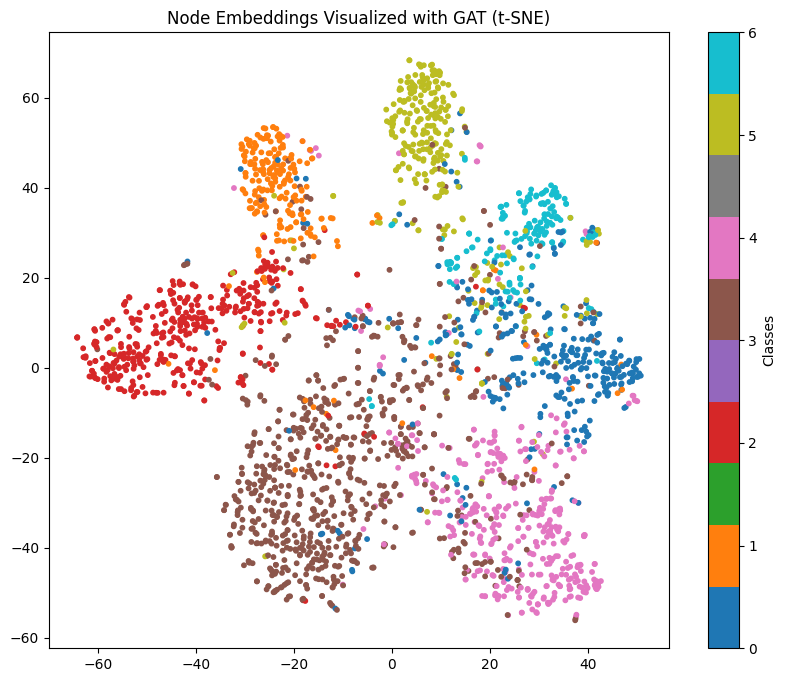

In [5]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt

# Load the Cora dataset
dataset = Planetoid(root="./data/Cora", name="Cora")

# Dataset summary
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")

# Graph data
data = dataset[0]
print("\nGraph Data:")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features per node: {data.num_node_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Training nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")

# Define the GAT model
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        # First GAT layer with attention
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        # Second GAT layer
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model
model = GAT(
    in_channels=dataset.num_node_features,
    hidden_channels=8,
    out_channels=dataset.num_classes,
    heads=8  # Number of attention heads in the first layer
).to("cuda" if torch.cuda.is_available() else "cpu")

# Transfer the graph data to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss()  # Negative Log-Likelihood Loss for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training loop
model.train()
epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss on training nodes
    loss.backward()  # Backward pass
    optimizer.step()  # Update model parameters

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Predicted class
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
    print(f"\nTest Accuracy: {acc.item() * 100:.2f}%")

# Visualize attention-based embeddings (Optional)
from sklearn.manifold import TSNE
import numpy as np

# Extract node embeddings
model.eval()
with torch.no_grad():
    embeddings = model.gat1(data.x, data.edge_index).cpu().numpy()

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=data.y.cpu().numpy(),
    cmap="tab10",
    s=10
)
plt.colorbar(scatter, label="Classes")
plt.title("Node Embeddings Visualized with GAT (t-SNE)")
plt.show()